In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!git clone "https://github.com/RichieHakim/basic_neural_processing_modules.git" "/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules"
!cd "/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules" && git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules' already exists and is not an empty directory.
Already up to date.


In [4]:
!pip install pycuda

In [5]:
import sys

# sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# sys.path.append('/Users/Josh/Documents/github_repos/')
sys.path.append(r'/content/drive/MyDrive/00 - ROI')
dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition, math_functions, classification
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead

## Import training data

In [6]:
import pickle

with open('/content/drive/MyDrive/00 - ROI/label_data/all_stat_files_20211022.pkl', 'rb') as file:
# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
# with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [7]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [8]:
# keys_toDelete = list(statFiles_scraped.keys())[:len(statFiles_scraped.keys())]
keys_toDelete = list(statFiles_scraped.keys())[2:]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [9]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# images_all = np.concatenate(sf_list, axis=0)
images_all = np.concatenate([sf_list[ii][:1000] for ii in range(len(sf_list))], axis=0)

images_all.shape

(1659, 36, 36)

In [10]:
# images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255
images_all_norm = (images_all / np.max(images_all, axis=(1,2), keepdims=True)) * 1


In [11]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train_all.shape, y_train_all.shape), (X_val_all.shape, y_val_all.shape)

(((1410, 36, 36), (1410,)), ((249, 36, 36), (249,)))

concatenated images shape: (9715, 36, 36)


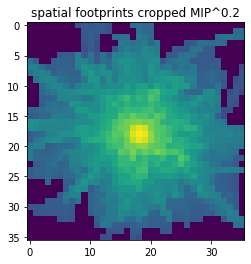

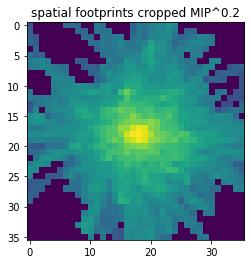

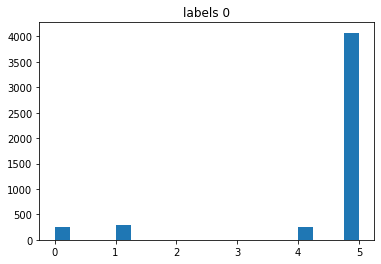

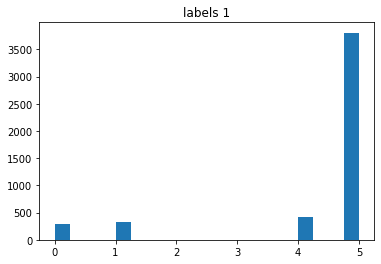

In [12]:
dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

# statFile_import_kwargs = {'out_height_width': [36,36],
#                           'max_footprint_width': 241,
#                           'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
images_labeled = (images_labeled / np.max(images_labeled, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [13]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [14]:
#code doesn't work with multiple open number maybe (?)

In [15]:
labels = classification.squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [16]:
duplicates = 1
balanced = False

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

if balanced:
  numToGetTo = np.sum(labels_dup==0)
  print(numToGetTo)
  for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
      if ii==3:
          numToGetTo = np.sum(labels_dup==0)/2
      else:
          numToGetTo = np.sum(labels_dup==0)

      idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
      images_dup = images_dup[idxToDelete==0,:,:]
      labels_dup = labels_dup[idxToDelete==0]

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 36, 36)
(9714,)
532
532
620
0
0
(9714, 36, 36)
(9714,)


In [17]:
# # create validation set

# ###### REMOVE WITH ENOUGH RAM
# images = images_dup
# labels = labels_dup

# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
# X_train, X_val, y_train, y_val = X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val
# (X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)





# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
# X_train, X_val, y_train, y_val = X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val
# (X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
X_train, y_train = X_labeled_train, y_labeled_train

X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((7771, 36, 36), (7771,)), ((1943, 36, 36), (1943,)))

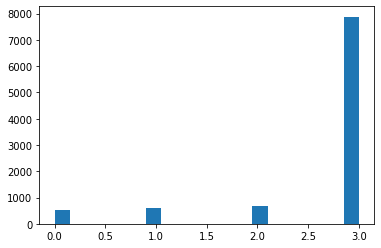

In [18]:
plt.figure()
plt.hist(labels_dup, 20);

In [19]:
def idx_to_oneHot(arr, n_classes=None):
    """
    Convert an array of class indices to matrix of
     one-hot vectors.
    RH 2021

    Args:
        arr (np.ndarray):
            1-D array of class indices.
        n_classes (int):
            Number of classes.
    
    Returns:
        oneHot (np.ndarray):
            2-D array of one-hot vectors.
    """
    if n_classes is None:
        n_classes = np.max(arr)+1
    oneHot = np.zeros((arr.size, n_classes))
    oneHot[np.arange(arr.size), arr] = 1
    return oneHot

In [20]:
def rh_cm(y_hat, y_true):
    """
    Compute the confusion matrix from y_hat and y_true.
    y_hat should be either predictions ().
    RH 2021

    Args:
        y_hat (np.ndarray): 
            numpy array of predictions or probabilities. 
            Either PREDICTIONS: 2-D array of booleans
             ('one hots') or 1-D array of predicted 
             class indices.
            Or PROBABILITIES: 2-D array floats ('one hot
             like')
        y_true (np.ndarray):
            1-D array of true class indices.
    """
    n_classes = np.max(y_true)+1
    if y_hat.ndim == 1:
        y_hat = idx_to_oneHot(y_hat, n_classes)
    cmat = y_hat.T @ idx_to_oneHot(y_true, n_classes)
    return cmat / np.sum(cmat, axis=0)[None,:]
#     return cmat / torch.sum(cmat, dim=0)[None,:]

## Define augmentation pipeline

In [21]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
# ######     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
    
    # # torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    # torchvision.transforms.GaussianBlur(kernel_size=5,
    #                                     sigma=(0.0001, 0.1)),
    
    
    # # # torchvision.transforms.RandomPerspective(distortion_scale=0.05, 
    # # #                                          p=0.5, 
    # # #                                          interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
    # # #                                          fill=0),
    # # torchvision.transforms.RandomAffine(
    # #                                     degrees=(-180,180),
    # #                                     translate=(0.05, 0.05),
    # #                                     scale=(0.9, 1.1), 
    # #                                     shear=(-7, 7, -7, 7), 
    # #                                     interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
    # #                                     fill=0, 
    # #                                     fillcolor=None, 
    # #                                     resample=None),
    
    torchvision.transforms.RandomHorizontalFlip(p=0.5),

    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.1, 0.1),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        # fillcolor=None, 
                                        resample=None),
    
    # augmentation.AddPoissonNoise(   scaler_bounds=(10, 50),
    #                                 prob=1,
    #                                 base=100,
    #                                 scaling='log'),

    # augmentation.AddGaussianNoise(  mean=0, 
    #                                 std=0.07,
    #                                 prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms



# dataset_train = util.dataset_simCLR(
#                                     X_train, 
#                                     y_train, 
# #                                     torch.tensor(X_train), 
# #                                     y_train, 
#                                     n_transforms=2, 
# #                                     class_weights=[1]*4,
# #                                     class_weights=[0.34, 0.33, 0.33, 0.00],
# #                                     class_weights=[0.0, 0.0, 0.0, 1.00],
# #                                     class_weights=np.array([0.34, 0.33, 0.33, 0.00])[y_train],
# #                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=2048,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
# #                                                 num_workers=32,
# #                                                 prefetch_factor=0,
# #                                                 persistent_workers=True,
#                                                 )

# # dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
# #                                     y_val, 
# #                                     n_transforms=2, 
# #                                     transform=scripted_transforms,
# #                                     DEVICE='cpu',
# #                                     dtype_X=torch.float32,
# #                                     dtype_y=torch.int64 )

# # dataloader_val = torch.utils.data.DataLoader(   dataset_val,
# #                                                 batch_size=128,
# #             #                                     sampler=sampler,
# #                                                 shuffle=True,
# #                                                 drop_last=True,
# #                                                 pin_memory=True,
# #                                                 num_workers=0,
# #                                                 )         



In [22]:
# import time

# %matplotlib inline
# tic=time.time()
# # for ii, im in enumerate(dataset_train):
# for ii,idx in enumerate(np.random.randint(0,X_train.shape[0], 5)):
# #     for jj in range(im[0])
# #     print(time.time() - tic)
# #     tic = time.time()
# #     print((im[0][0]).shape)
#     print(dataset_train[idx][3])
#     fig, axs = plt.subplots(2)
#     for jj, ax in enumerate(axs):
# #         ax.imshow(im[0][j].cpu().squeeze())
#         ax.imshow(dataset_train[idx][0][jj].cpu().squeeze())
# #     if ii > 5:
# #         break

## Train

In [23]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [24]:
class ModelTackOn(torch.nn.Module):
  def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=[]):
    super(ModelTackOn, self).__init__()
    self.base_model = base_model
    final_base_layer = list(un_modified_model.children())[-1]
    # final_base_layer = list(list(model.children())[-1].children())[-1]
    # print(final_base_layer)

    self.pre_head_fc_lst = []
    self.post_head_fc_lst = []
    self.classifier_fc_lst = []

    for i, pre_head_fc in enumerate(pre_head_fc_sizes):
      if i == 0:
        in_features = final_base_layer.in_features if hasattr(final_base_layer,'in_features') else 512
      else:
        in_features = pre_head_fc_sizes[i - 1]
      fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
      self.add_module(f'PreHead_{i}', fc_layer)
      self.pre_head_fc_lst.append(fc_layer)

      if i < len(pre_head_fc_sizes) - 1:
        non_linearity = torch.nn.ReLU()
        self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
        self.pre_head_fc_lst.append(non_linearity)

    
    for i, post_head_fc in enumerate(post_head_fc_sizes):
      if i == 0:
        in_features = pre_head_fc_sizes[-1]
      else:
        in_features = post_head_fc_sizes[i - 1]
      fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
      self.add_module(f'PostHead_{i}', fc_layer)
      self.post_head_fc_lst.append(fc_layer)

      if i < len(post_head_fc_sizes) - 1:
        non_linearity = torch.nn.ReLU()
        self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
        self.pre_head_fc_lst.append(non_linearity)
    
    if classifier_fc_sizes:
      for i, classifier_fc in enumerate(classifier_fc_sizes):
        if i == 0:
          in_features = pre_head_fc_sizes[-1]
        else:
          in_features = classifier_fc_sizes[i - 1]
        fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
        self.add_module(f'Classifier_{i}', fc_layer)
        self.classifier_fc_lst.append(fc_layer)
    
  def forward(self, X):
    interim = self.base_model(X)
    interim = self.get_head(interim)
    interim = self.get_latent(interim)
    return interim
  
  def forward_class(self, X):
    interim = self.base_model(X)
    interim = self.get_head(interim)
    interim = self.classify(interim)
    return interim

  def forward_latent(self, X):
    interim = self.base_model(X)
    interim = self.get_head(interim)
    interim = self.get_latent(interim)
    return interim

  def predict_proba(self, X):
    logit = self.forward_class(X)
    return torch.nn.functional.softmax(logit, dim=-1)
  



  def get_head(self, base_out):
    # print('base_out', base_out.shape)
    head = base_out
    for pre_head_layer in self.pre_head_fc_lst:
      # print('pre_head_layer', pre_head_layer.in_features)
      head = pre_head_layer(head)
      # print('head', head.shape)
    return head
  
  def get_latent(self, head):
    latent = head
    for post_head_layer in self.post_head_fc_lst:
      latent = post_head_layer(latent)
    return latent
  
  def classify(self, head):
    logit = head
    for classifier_layer in self.classifier_fc_lst:
      logit = classifier_layer(logit)
    return logit
  

  def set_pre_head_grad(self, requires_grad=True):
    for pre_head_layer in self.pre_head_fc_lst:
      pre_head_layer.requies_grad = requires_grad
  
  def set_post_head_grad(self, requires_grad=True):
    for post_head_layer in self.post_head_fc_lst:
      post_head_layer.requies_grad = requires_grad
    
  def set_classifier_grad(self, requires_grad=True):
    for classifier_layer in self.classifier_fc_lst:
      classifier_layer.requies_grad = requires_grad

  def prep_contrast(self):
    self.set_pre_head_grad(requires_grad=True)
    self.set_post_head_grad(requires_grad=True)
    self.set_classifier_grad(requires_grad=False)

  def prep_classifier(self):
    self.set_pre_head_grad(requires_grad=False)
    self.set_post_head_grad(requires_grad=False)
    self.set_classifier_grad(requires_grad=True)


In [25]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#   params = layer.parameters()
#   for param in params:
#     param.requires_grad = True

In [26]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

from sklearn.linear_model import LogisticRegression
sq = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))


In [27]:
model = ModelTackOn(sq.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[256], post_head_fc_sizes=[128], classifier_fc_sizes=[len(np.unique(y_train))]).to(DEVICE)
# model = ModelTackOn(sq.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=[len(np.unique(y_train))]).to(DEVICE)
# model = ModelTackOn(sq.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train()

ModelTackOn(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [28]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion_class = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=2e-1, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0002,
#                                                    gamma=1,
                                                  )

optimizer_class = Adam(model.parameters(), lr=2e-1)

# val_obj = training_simCLR.validation_Obj(   X_val,
#                                             y_val,
#                                             model,
#                                             criterion,
#                                             DEVICE=DEVICE,
#                                             dtype_X=torch.float32,
#                                             dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

# # classHead = HeadModel(model, RandomForestClassifier)
# classHead = training_classHead.HeadModel(model, LogisticRegression)
# dataset_train.headmodel = classHead
# # dataset_train.headmodel = None

losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [29]:
import pandas as pd
tracking_df_cols = ['sample_id',
                    'epoch',
                    'batch_iter',
                    'labels'
                    ]
tracking_df = pd.DataFrame(columns=tracking_df_cols)

In [30]:
from torch.utils.data import Dataset


In [31]:
pct_batch_size = 1.0

# dataset_train = util.dataset_supervised(
#                                     X_train,
#                                     y_train,
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64
#                                     )

dataset_train = util.dataset_simCLR(
                                    # torch.as_tensor(X_train, device=DEVICE, dtype=torch.float32), 
                                    # torch.as_tensor(y_train, device=DEVICE, dtype=torch.float32),

                                    torch.as_tensor(X_train_all, device=DEVICE, dtype=torch.float32), 
                                    torch.as_tensor(y_train_all, device=DEVICE, dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE=DEVICE,
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64
                                    )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=int(pct_batch_size*X_train.shape[0]),
                                                # batch_size=64,
                                                shuffle=True,
                                                drop_last=True,
                                                # pin_memory=True,
                                                # num_workers=16,
                                                # persistent_workers=True,
                                                # prefetch_factor=0
                                                )



In [32]:
import sys
sys.getsizeof(X_labeled_train)/1e9

0.080569856

In [33]:
from sklearn.metrics import confusion_matrix

def get_cm(pred_cm, y_cm, plot=False):
  ### NOTE — RETURNS A MATRIX WITH PREDICTION NUM ASSOCIATED WITH ROW NUM
  ### AND COLUMN NUM ASSOCIATED WITH TRUE VALUE. (TRANSPOSE OF SKLEARN OUTPUT.)

  cm = confusion_matrix(y_cm, np.argmax(pred_cm, -1))
  cm = cm / np.where(cm.sum(1, keepdims=True)==0, np.ones_like(cm.sum(1, keepdims=True)), cm.sum(1, keepdims=True))
  
  # cm = classification.confusion_matrix(y_hat, y_labeled_val)
  # print(cm)
  
  if plot:
    plt.figure()
    plt.imshow(cm)
    plt.colorbar()
    plt.show()
  
  return cm.T

In [34]:
x_feed_through_tr = util.tile_channels(torch.as_tensor(X_train[:,None,...], device=DEVICE, dtype=torch.float32), dim=1)
x_feed_through_val = util.tile_channels(torch.as_tensor(X_val[:,None,...], device=DEVICE, dtype=torch.float32), dim=1)
x_feed_through_te = util.tile_channels(torch.as_tensor(X_test[:,None,...], device=DEVICE, dtype=torch.float32), dim=1)

cpu_tr = sq(x_feed_through_tr)
cpu_val = sq(x_feed_through_val)
cpu_te = sq(x_feed_through_te)
cpu_tr.shape, cpu_val.shape, cpu_tr.squeeze().shape, cpu_val.squeeze().shape

(torch.Size([7771, 512]),
 torch.Size([971, 512]),
 torch.Size([7771, 512]),
 torch.Size([971, 512]))

In [35]:
# num_tr_ex = X_val.shape[0]

# solver = 'liblinear'
# C_reg = 0.01
# logreg = LogisticRegression(solver=solver, C=C_reg)

# base_features_train = cpu_tr.cpu().detach().numpy()
# logreg.fit(base_features_train, y_train)
# base_features_val = cpu_val.cpu().detach().numpy()

# base_features_te = cpu_te.cpu().detach().numpy()

# logistic_pred_train = get_cm(logreg.predict_proba(base_features_train), y_train)
# logistic_pred_val = get_cm(logreg.predict_proba(base_features_val), y_val)
# logistic_pred_test = get_cm(logreg.predict_proba(base_features_te), y_test)


# x_feed_through_tr.to(DEVICE)
# x_feed_through_val.to(DEVICE)
# x_feed_through_te.to(DEVICE)

# print(x_feed_through_tr.shape, x_feed_through_val.shape)

In [36]:
import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [37]:
torch_helpers.show_all_tensors(globals())

var: x_feed_through_tr,   device:cuda:0,   shape: torch.Size([7771, 3, 36, 36]),   size: 0.120854592 GB,   requires_grad: False
var: x_feed_through_val,   device:cuda:0,   shape: torch.Size([971, 3, 36, 36]),   size: 0.015100992 GB,   requires_grad: False
var: x_feed_through_te,   device:cuda:0,   shape: torch.Size([972, 3, 36, 36]),   size: 0.015116544 GB,   requires_grad: False
var: cpu_tr,   device:cuda:0,   shape: torch.Size([7771, 512]),   size: 0.015915008 GB,   requires_grad: False
var: cpu_val,   device:cuda:0,   shape: torch.Size([971, 512]),   size: 0.001988608 GB,   requires_grad: False
var: cpu_te,   device:cuda:0,   shape: torch.Size([972, 512]),   size: 0.001990656 GB,   requires_grad: False


epoch: 0
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9050315022468567
Validation Acc: 0.8908342123031616


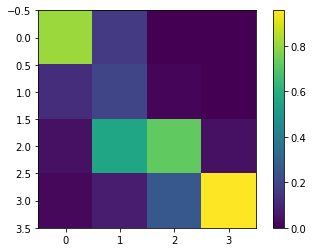

[[8.12500000e-01 1.63636372e-01 1.49468391e-19 0.00000000e+00]
 [1.25000000e-01 2.00001136e-01 1.63934426e-02 1.26078695e-31]
 [4.16666667e-02 5.63635183e-01 7.21311475e-01 4.46021059e-02]
 [2.08333333e-02 7.27273089e-02 2.62295082e-01 9.55397894e-01]]
epoch: 1
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9216316938400269
Validation Acc: 0.8671473264694214


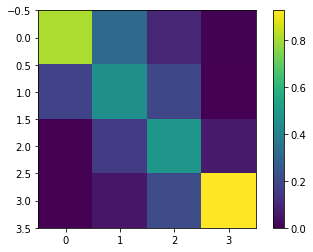

[[0.81231355 0.32009687 0.09836066 0.00371747]
 [0.18768645 0.46172131 0.19672162 0.00249826]
 [0.         0.16363637 0.48892918 0.06689461]
 [0.         0.05454545 0.21598854 0.92688966]]
epoch: 2
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9405481219291687
Validation Acc: 0.871266782283783


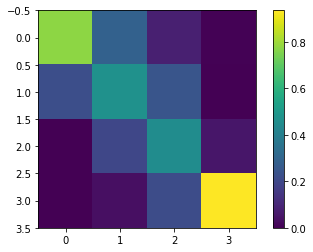

[[7.74765651e-01 2.92134118e-01 8.20594180e-02 4.95660793e-03]
 [2.25234349e-01 4.71502295e-01 2.45660818e-01 2.52892884e-03]
 [0.00000000e+00 1.98720828e-01 4.56455754e-01 5.71978032e-02]
 [5.57600013e-45 3.76427589e-02 2.15824010e-01 9.35316660e-01]]
epoch: 3
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9517436027526855
Validation Acc: 0.8733264803886414


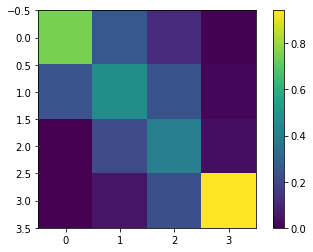

[[0.74999986 0.26135667 0.1147539  0.00630689]
 [0.24824586 0.46607346 0.24588727 0.015931  ]
 [0.         0.21802096 0.40985063 0.03476405]
 [0.00175428 0.05454891 0.2295082  0.94299807]]
epoch: 4
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.937845766544342
Validation Acc: 0.9001030325889587


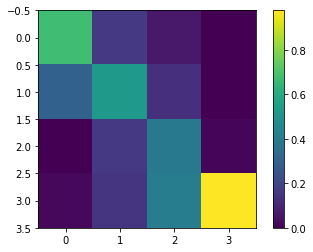

[[6.76774273e-01 1.63696624e-01 6.55737705e-02 1.23915738e-03]
 [3.02392394e-01 5.27181095e-01 1.31280254e-01 2.47831836e-03]
 [2.75476459e-22 1.63667742e-01 3.94480756e-01 1.85873572e-02]
 [2.08333333e-02 1.45454539e-01 4.08665219e-01 9.77695167e-01]]
epoch: 5
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9372023940086365
Validation Acc: 0.8815654516220093


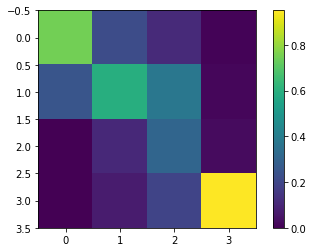

[[7.49999916e-01 2.21307213e-01 1.14754098e-01 7.43494437e-03]
 [2.50000084e-01 5.96678609e-01 3.76985597e-01 1.48690892e-02]
 [0.00000000e+00 1.09286921e-01 3.11623986e-01 2.63928905e-02]
 [2.71936088e-14 7.27272574e-02 1.96636318e-01 9.51303076e-01]]
epoch: 6
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.92665034532547
Validation Acc: 0.8774459958076477


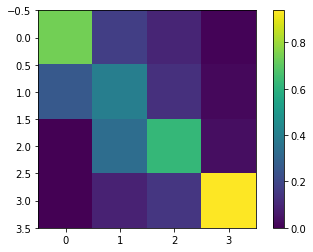

[[7.36614692e-01 1.73504952e-01 9.83606555e-02 7.57325250e-03]
 [2.62975213e-01 4.01012385e-01 1.31147518e-01 2.03881098e-02]
 [4.10094529e-04 3.34573583e-01 6.22950343e-01 3.42367624e-02]
 [0.00000000e+00 9.09090797e-02 1.47541483e-01 9.37801875e-01]]
epoch: 7
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.941191554069519
Validation Acc: 0.8774459958076477


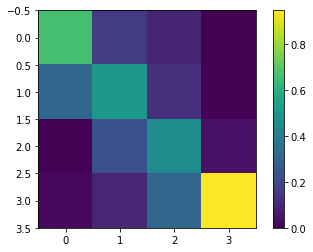

[[6.66679906e-01 1.63634606e-01 9.84404517e-02 4.95662949e-03]
 [3.12486757e-01 5.03198647e-01 1.31249957e-01 4.25820638e-03]
 [1.35708021e-12 2.30678778e-01 4.59142820e-01 4.44694912e-02]
 [2.08333371e-02 1.02487968e-01 3.11166771e-01 9.46315673e-01]]
epoch: 8
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9579204320907593
Validation Acc: 0.8836251497268677


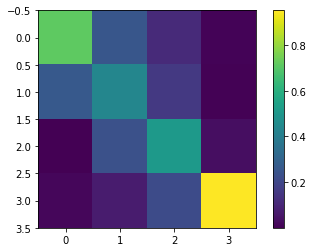

[[7.16983137e-01 2.55348556e-01 1.14754097e-01 8.30986605e-03]
 [2.64566298e-01 4.35073572e-01 1.56248672e-01 3.98922848e-03]
 [1.01705719e-07 2.36148095e-01 5.10232563e-01 3.63242049e-02]
 [1.84504626e-02 7.34297776e-02 2.18764667e-01 9.51376701e-01]]
epoch: 9
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9514862298965454
Validation Acc: 0.8805355429649353


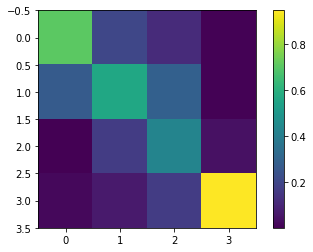

[[7.08051472e-01 2.00083769e-01 1.14792166e-01 6.19767673e-03]
 [2.71116498e-01 5.62455319e-01 2.88671502e-01 4.83027820e-03]
 [5.71960363e-09 1.68516965e-01 4.27483467e-01 4.31850946e-02]
 [2.08320246e-02 6.89439468e-02 1.69052864e-01 9.45786950e-01]]
epoch: 10
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.95110023021698
Validation Acc: 0.8692070245742798


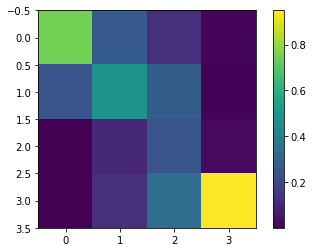

[[7.49596894e-01 2.72645795e-01 1.33100081e-01 1.19761673e-02]
 [2.50031021e-01 4.91258622e-01 2.80227949e-01 9.18773881e-03]
 [7.98333408e-08 1.05587756e-01 2.48473509e-01 2.90308262e-02]
 [3.72004814e-04 1.30507827e-01 3.38198461e-01 9.49805268e-01]]
epoch: 11
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9580491185188293
Validation Acc: 0.8887745141983032


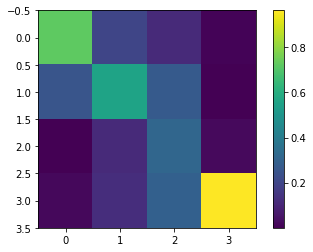

[[7.25257752e-01 2.00000015e-01 1.15779501e-01 8.67419255e-03]
 [2.53943894e-01 5.58706878e-01 2.71199088e-01 2.27166964e-03]
 [4.60149564e-08 1.15048235e-01 3.16352399e-01 2.57698295e-02]
 [2.07983081e-02 1.26244872e-01 2.96669011e-01 9.63284308e-01]]
epoch: 12
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.937845766544342
Validation Acc: 0.8877446055412292


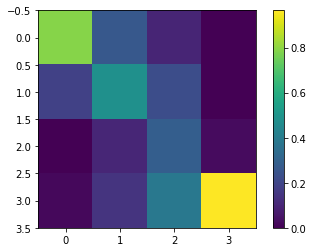

[[7.91666864e-01 2.65229159e-01 9.83606555e-02 3.71747212e-03]
 [1.86203690e-01 4.85931839e-01 2.27983612e-01 2.26772606e-03]
 [2.52747987e-30 1.03347748e-01 2.88601580e-01 2.87230603e-02]
 [2.21294462e-02 1.45491254e-01 3.85054152e-01 9.65291742e-01]]
epoch: 13
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9610088467597961
Validation Acc: 0.8722966313362122


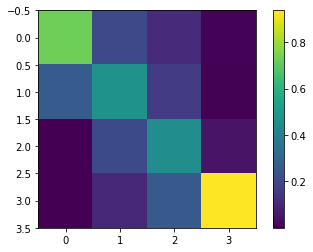

[[7.28556880e-01 2.07263194e-01 1.11382774e-01 8.69668793e-03]
 [2.70881375e-01 4.76465180e-01 1.65828607e-01 5.49288151e-03]
 [9.74459508e-05 2.10649562e-01 4.59428816e-01 4.90675155e-02]
 [4.64298317e-04 1.05622064e-01 2.63359802e-01 9.36742915e-01]]
epoch: 14
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.941062867641449
Validation Acc: 0.8846550583839417


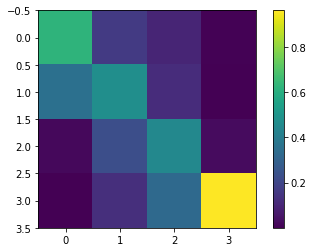

[[6.23703299e-01 1.63535257e-01 9.83606558e-02 7.38549968e-03]
 [3.55437729e-01 4.76592179e-01 1.23751381e-01 3.19977583e-03]
 [2.08575036e-02 2.30952375e-01 4.48984913e-01 2.82707797e-02]
 [1.46819216e-06 1.28920189e-01 3.28903051e-01 9.61143945e-01]]
epoch: 15
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9715608954429626
Validation Acc: 0.8805355429649353


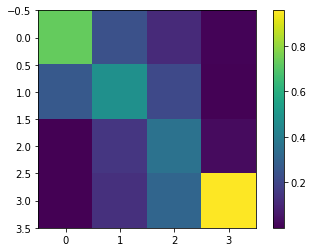

[[7.29317250e-01 2.36621516e-01 1.15051415e-01 8.68005895e-03]
 [2.67609070e-01 4.79482374e-01 2.12433038e-01 5.96895314e-03]
 [1.77168037e-05 1.50900765e-01 3.60353978e-01 2.88966916e-02]
 [3.05596346e-03 1.32995345e-01 3.12161569e-01 9.56454296e-01]]
epoch: 16
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9670569896697998
Validation Acc: 0.8764160871505737


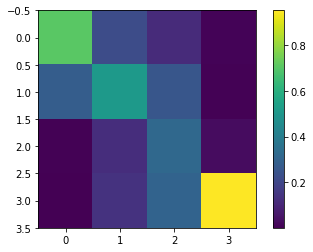

[[7.10928428e-01 2.19992039e-01 1.18841306e-01 8.68392217e-03]
 [2.82773857e-01 5.16380674e-01 2.55416001e-01 5.98982138e-03]
 [6.29719099e-03 1.25808102e-01 3.20574222e-01 3.24415856e-02]
 [5.24335937e-07 1.37819185e-01 3.05168471e-01 9.52884671e-01]]
epoch: 17
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.965641438961029
Validation Acc: 0.8764160871505737


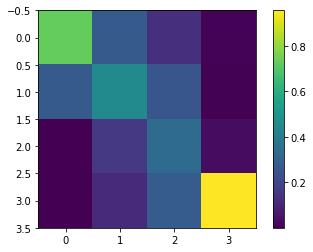

[[7.29186982e-01 2.70838425e-01 1.31147541e-01 8.37951883e-03]
 [2.70790216e-01 4.57758809e-01 2.57164372e-01 5.39442243e-03]
 [4.57244901e-09 1.57265770e-01 3.32848947e-01 3.09506105e-02]
 [2.27970061e-05 1.14136996e-01 2.78839139e-01 9.55275448e-01]]
epoch: 18
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9446660280227661
Validation Acc: 0.8867147564888


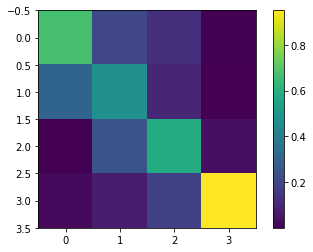

[[6.71200171e-01 2.01429374e-01 1.31147541e-01 6.19578686e-03]
 [3.07966249e-01 4.79013168e-01 1.01408774e-01 2.52950854e-03]
 [3.03855253e-07 2.46830201e-01 5.83185944e-01 4.07619794e-02]
 [2.08332762e-02 7.27272572e-02 1.84257741e-01 9.50512725e-01]]
epoch: 19
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9759361147880554
Validation Acc: 0.8753862380981445


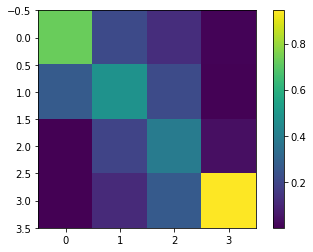

[[7.30055381e-01 2.12864198e-01 1.24811885e-01 8.67758262e-03]
 [2.69849851e-01 4.81424027e-01 2.14604964e-01 6.62400353e-03]
 [8.31378752e-05 1.92462518e-01 3.93257655e-01 4.04242385e-02]
 [1.16295890e-05 1.13249258e-01 2.67325497e-01 9.44274175e-01]]
epoch: 20
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9764508605003357
Validation Acc: 0.8774459958076477


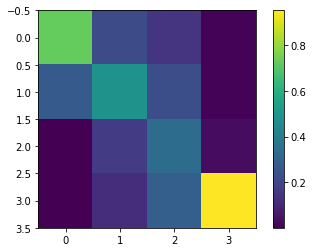

[[7.29218194e-01 2.18159600e-01 1.47478614e-01 8.67643561e-03]
 [2.70733646e-01 4.85799205e-01 2.28595534e-01 7.75869073e-03]
 [4.52352229e-05 1.70885367e-01 3.35554738e-01 3.06756375e-02]
 [2.92529192e-06 1.25155828e-01 2.88371114e-01 9.52889236e-01]]
epoch: 21
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9764508605003357
Validation Acc: 0.8743563890457153


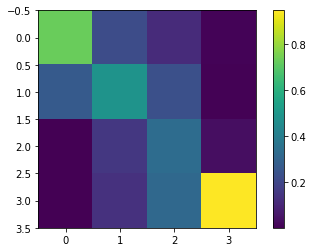

[[7.30797371e-01 2.21461764e-01 1.14991322e-01 8.67362340e-03]
 [2.69187209e-01 4.88096184e-01 2.30107826e-01 7.38875140e-03]
 [8.41810807e-06 1.55235047e-01 3.36063426e-01 3.64233244e-02]
 [7.00163359e-06 1.35207004e-01 3.18837427e-01 9.47514301e-01]]
epoch: 22
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.964097261428833
Validation Acc: 0.8702369332313538


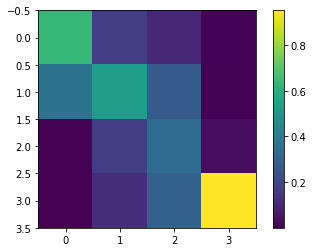

[[6.34820027e-01 1.72469732e-01 1.04745224e-01 8.60055605e-03]
 [3.64179274e-01 5.30893306e-01 2.69066163e-01 7.04154896e-03]
 [1.00068828e-03 1.71093493e-01 3.30843991e-01 3.29246047e-02]
 [1.09948812e-08 1.25543469e-01 2.95344622e-01 9.51433290e-01]]
epoch: 23
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.973748505115509
Validation Acc: 0.8692070245742798


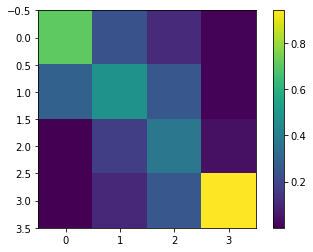

[[7.07960624e-01 2.36358934e-01 1.14752771e-01 9.90605559e-03]
 [2.91811391e-01 4.79410604e-01 2.54130886e-01 7.82982642e-03]
 [2.27341139e-04 1.76240723e-01 3.74456510e-01 4.14178429e-02]
 [6.44509688e-07 1.07989739e-01 2.56659833e-01 9.40846275e-01]]
epoch: 24
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9520009756088257
Validation Acc: 0.8681771755218506


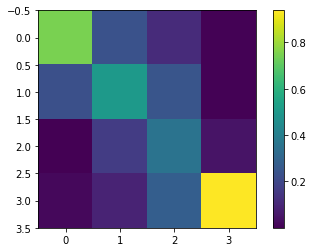

[[7.49991732e-01 2.36731197e-01 1.14753672e-01 7.08335181e-03]
 [2.29174930e-01 5.01911941e-01 2.45451369e-01 5.46735988e-03]
 [4.68551117e-09 1.68298631e-01 3.58353038e-01 4.96683235e-02]
 [2.08333333e-02 9.30582309e-02 2.81441921e-01 9.37780965e-01]]
epoch: 25
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...
Epoch 75 for classification training...
Epoch 100 for classification training...
Training Acc: 0.9673143029212952
Validation Acc: 0.8753862380981445


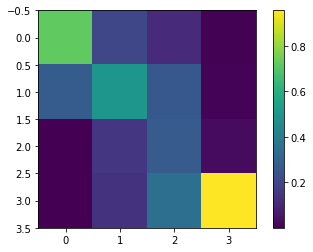

[[7.23412948e-01 2.05202277e-01 1.14756347e-01 7.45393627e-03]
 [2.76445991e-01 5.03480198e-01 2.61750178e-01 7.57687217e-03]
 [1.14794372e-04 1.50337562e-01 2.73885034e-01 2.88558038e-02]
 [2.62672623e-05 1.40979963e-01 3.49608441e-01 9.56113388e-01]]
epoch: 26
Epoch 0 for classification training...
Epoch 25 for classification training...
Epoch 50 for classification training...


In [ ]:
%matplotlib inline


x_feed_through_tr.to(DEVICE)
x_feed_through_val.to(DEVICE)
x_feed_through_te.to(DEVICE)
y_train_torch = torch.as_tensor(y_train).to(DEVICE)
y_val_torch = torch.as_tensor(y_val).to(DEVICE)
y_test_torch = torch.as_tensor(y_test).to(DEVICE)

cpu_tr.to(DEVICE)
cpu_val.to(DEVICE)
model.to(DEVICE)
base_model_frozen.to(DEVICE)

penalized_params = list(model.modules())[-1].parameters()
penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)
early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0
l2_alpha = 0.1




# logreg = LogisticRegression(solver='liblinear')
# logreg_predict_head = LogisticRegression(solver='liblinear')
dataset_train.classification_model = None

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
#                                                    gamma=1-0.001,
# #                                                    gamma=1,
#                                                   )
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    
    model.prep_contrast()
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
#                                 validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )
    

    model.prep_classifier()
    
    for epoch_classify in range(101):
      if epoch_classify%25 == 0:
        print(f'Epoch {epoch_classify} for classification training...')
      optimizer_class.zero_grad()
      features_train = model.forward_class(torch.as_tensor((x_feed_through_tr), device=DEVICE, dtype=torch.float32))
      loss_classification = criterion_class(features_train, y_train_torch)
      loss_classification.backward()
      optimizer_class.step()

    features_train = model.forward_class(torch.as_tensor((x_feed_through_tr), device=DEVICE, dtype=torch.float32))
    
    # dataset_train.net_model = model #copy.deepcopy(model).to('cpu')
    # dataset_train.net_model = model.get_latent
    # dataset_train.classification_model = model.classify
    
    dataset_train.net_model = model
    dataset_train.classification_model = model
    

    sample_id_num = np.arange(x_feed_through_val.shape[0])
    epoch_val = epoch
    batch_val = -1
    features_val = model.forward_class(torch.as_tensor((x_feed_through_val), device=DEVICE, dtype=torch.float32))
    # features_val = features_val.detach().cpu()

    tr_acc = torch.mean(torch.as_tensor(torch.argmax(features_train, axis=-1) == y_train_torch, dtype=torch.float32))
    val_acc = torch.mean(torch.as_tensor(torch.argmax(features_val, axis=-1) == y_val_torch, dtype=torch.float32))
    acc.append((tr_acc, val_acc))
    print(f'Training Acc: {acc[-1][0]}')
    print(f'Validation Acc: {acc[-1][1]}')



    # p_tmp = logreg.predict_proba(features_val)
    p_tmp = torch.nn.functional.softmax(features_val, dim=-1)
    logits = p_tmp
    # logits = np.log(1/(1/p_tmp - 1))

    # col_vals = [sample_id_num, epoch_val, batch_val, y_val]
    # setup = np.empty((len(sample_id_num), len(col_vals)))
    # for icv, col_val in enumerate(col_vals):
    #   setup[:, icv] = col_val
    # tmp_tracking_np = np.concatenate([setup, logits], axis=1)

    # tmp_tracking_df = pd.DataFrame(tmp_tracking_np, index=sample_id_num, columns=tracking_df_cols + [f'logits_{i}' for i in range(logits.shape[1])])
    # tracking_df = tracking_df.append(tmp_tracking_df, ignore_index=True)
    # display(tracking_df)







    # features_val = model(torch.as_tensor((x_feed_through_val), device=DEVICE, dtype=torch.float32))
    # features_val = features_val.detach().cpu()



    # logreg_predict_head.fit(features_train, y_labeled_train)
    # y_hat = logreg_predict_head.predict_proba(features_val)

    y_hat = p_tmp.detach().cpu().numpy()
    # y_hat = logreg.predict_proba(features_val)
    
    cm = rh_cm(y_hat, y_val)
    plt.figure()
    plt.imshow(cm)
    plt.colorbar()
    plt.show()
    print(cm)

    # tracking_df = tracking_df.append(pd.DataFrame([np.array([100, 0, 0, 0])], index=tracking_df_cols), ignore_index=True)
    
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
#     classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
#     proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
#     final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)


In [ ]:
torch_helpers.show_all_tensors(globals())


In [ ]:
break

In [ ]:
b

In [ ]:
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git add old_stuff
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git status
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git commit -m "Introducing ResNet and validating process"
!cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git push

In [ ]:
!git config --global user.email "$indianajonesjz@gmail.com"
!git config --global user.name "$joshuazimmer"

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(acc)

In [ ]:
features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
# features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
logreg.fit(features_train, y_labeled_train)
y_hat = logreg.predict_proba(features_train)
cm = rh_cm(y_hat, y_labeled_train)

print(cm)

plt.figure()
plt.imshow(cm)
plt.colorbar()

In [ ]:
proba = classHead.predict_proba(dataset_train.X)

In [ ]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [ ]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

In [ ]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

In [ ]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [ ]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

In [ ]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


In [ ]:
plt.figure()
plt.imshow(features.cpu().detach(), aspect='auto', interpolation='none')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()